<a href="https://colab.research.google.com/github/Hanhpt23/Segmentation-with-Unet/blob/main/UnetCvC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link with google driver

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Deep learning/20.GitHub/CVC-Dataset
!ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/Deep learning/20.GitHub/CVC-Dataset
'1d09RO5dKc5IZdh9H00MS-prD5IBKwMYO?usp=drive_link'   images   labels


### Buidling Unet model

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch import nn
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import os, math
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import numpy as np


In [ ]:

class UNet(nn.Module):

      def __init__(self, in_channels=3, out_channels=1, init_features=32):
            super(UNet, self).__init__()

            features = init_features
            self.encoder1 = UNet._block(in_channels, features)
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.encoder2 = UNet._block(features, features * 2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.encoder3 = UNet._block(features * 2, features * 4)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.encoder4 = UNet._block(features * 4, features * 8)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

            self.bottleneck = UNet._block(features * 8, features * 16)

            self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
            )
            self.decoder4 = UNet._block((features * 8) * 2, features * 8)
            self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
            )
            self.decoder3 = UNet._block((features * 4) * 2, features * 4)
            self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
            )
            self.decoder2 = UNet._block((features * 2) * 2, features * 2)
            self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
            )
            self.decoder1 = UNet._block(features * 2, features)

            self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
            )

      def _block(in_channels, features):
            return nn.Sequential(
                        nn.Conv2d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False),
                        nn.BatchNorm2d(num_features=features),
                        nn.ReLU(inplace=True),
                        nn.Conv2d( in_channels=features,out_channels=features,kernel_size=3,padding=1, bias=False),
                        nn.BatchNorm2d(num_features=features),
                        nn.ReLU(inplace=True)
                        )

      def forward(self, x):
            enc1 = self.encoder1(x)
            enc2 = self.encoder2(self.pool1(enc1))
            enc3 = self.encoder3(self.pool2(enc2))
            enc4 = self.encoder4(self.pool3(enc3))

            bottleneck = self.bottleneck(self.pool4(enc4))

            dec4 = self.upconv4(bottleneck)
            dec4 = torch.cat((dec4, enc4), dim=1)
            dec4 = self.decoder4(dec4)
            dec3 = self.upconv3(dec4)
            dec3 = torch.cat((dec3, enc3), dim=1)
            dec3 = self.decoder3(dec3)
            dec2 = self.upconv2(dec3)
            dec2 = torch.cat((dec2, enc2), dim=1)
            dec2 = self.decoder2(dec2)
            dec1 = self.upconv1(dec2)
            dec1 = torch.cat((dec1, enc1), dim=1)
            dec1 = self.decoder1(dec1)

            return torch.sigmoid(self.conv(dec1))

aa = torch.rand((1, 3, 384, 288))
unet = UNet()
print('Output Unet:', unet(aa).shape)
# summary(unet,( 3, 384, 288) )

Output Unet: torch.Size([1, 1, 384, 288])


### Test model on the cvc dataset

Train Unet model with cvc dataset
you can download dataset by following the link below
https://drive.google.com/drive/folders/1d09RO5dKc5IZdh9H00MS-prD5IBKwMYO?usp=drive_link

In [ ]:

images_path = 'images/'
label_path = 'labels/'

Load and test dataset

In [ ]:
image_file_names = []
for root, dirs, files in os.walk(images_path):
      image_file_names.extend(files)
      images = sorted(image_file_names)
print(len(), images[:5])


20 ['1.png', '10.png', '11.png', '12.png', '13.png']


In [ ]:
label_file_names = []
for root, dirs, files in os.walk(label_path):
      label_file_names.extend(files)
      labels = sorted(label_file_names)
print(len(labels), labels[:5])

20 ['1.png', '10.png', '11.png', '12.png', '13.png']


Images Visualization

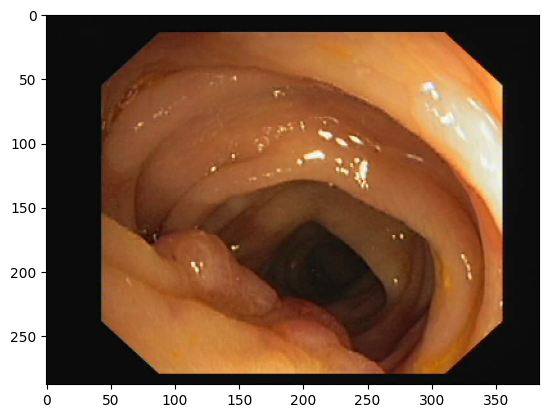

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img_path = os.path.join(images_path, images[0])
img = np.asarray(Image.open(img_path))
imgplot = plt.imshow(img)

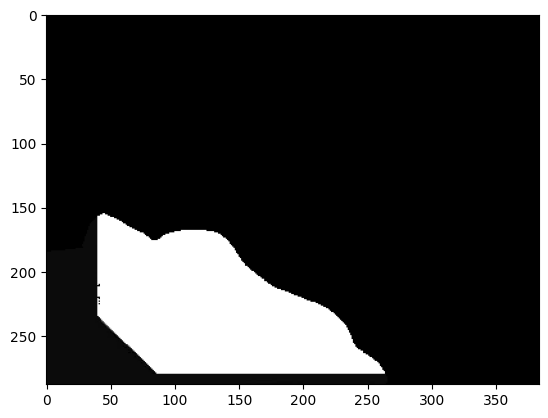

In [ ]:
gt_path = os.path.join(label_path, labels[0])
img = np.asarray(Image.open(gt_path))
imgplot = plt.imshow(img)

### Buid dataloader for the dataset using pytorch

1. Load dataset
2. Rezise dataset
3. Tranform to tensor

In [ ]:

class CustomDataset(Dataset):
    def __init__(self, img_path, gt_path, transform = None):

        self.imgs_path = img_path
        self.gts_path = gt_path
        self.PILtoTensor = torchvision.transforms.ToTensor()
        self.transform = transform

        # Calling images and sorting them
        image_file_names = []
        for root, dirs, files in os.walk(self.imgs_path):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # Calling labels and sorting them
        annotations_file_names = []
        for root, dirs, files in os.walk(self.gts_path):
            annotations_file_names.extend(files)
        self.annotations = sorted(annotations_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        # return the number of images
        return len(self.images)

    def __getitem__(self, idx):
        # load image[idx] and transform to tensor
        image = Image.open(os.path.join(self.imgs_path, self.images[idx]))
        imgPIL = image.resize((256, 256))
        input_imgsT = self.PILtoTensor( imgPIL )

        # load label[idx] and transform to tensor
        segmentation_map = Image.open( os.path.join(self.gts_path, self.annotations[idx]))
        desired_img  = torchvision.transforms.Grayscale()(segmentation_map)
        desired_img = desired_img.resize((256, 256))
        desired_imgT = torchvision.transforms.ToTensor()( desired_img )

        return input_imgsT, desired_imgT

dataset = CustomDataset(images_path, label_path)
# print(dataset[0])
train_len, test_len = int(0.8*len(dataset)), len(dataset) - int(0.8*len(dataset))
print('Total dataset:', len(dataset), 'Train dataset:', train_len, 'Test dataset:', test_len)

BATCH =4
train_data, test_data = torch.utils.data.random_split(dataset, [train_len, test_len])
train_dataloader = DataLoader(train_data, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH, shuffle=False)

img, label = next(iter(train_dataloader))
print(img[0].shape, label[0].shape)

Total dataset: 20 Train dataset: 16 Test dataset: 4
torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


### Train model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using: {device} to train the models")
model = unet.to(device)

import torch.optim as optim
loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train(train_dataloader, model, loss_function, optimizer):

    model.train()
    training_loss = 0.0

    # Loop through dataloader data batch
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        pred = model(X)
        total_loss = loss_function(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        training_loss += total_loss.item()


    return training_loss/len(train_dataloader)

final_epoch = 30
for epoch in range(final_epoch+1):
    train_loss = train(train_dataloader, model, loss_function, optimizer)
    if epoch % 10 ==0:
      print(f'Epoch: {epoch}, Total training loss: {train_loss}')

Using: cuda to train the models
Epoch: 0, Total training loss: 0.02303859917446971
Epoch: 10, Total training loss: 0.022050098050385714
Epoch: 20, Total training loss: 0.02270865999162197
Epoch: 30, Total training loss: 0.02178544783964753


Save model

In [ ]:
torch.save(model.state_dict(), f'model_at_epoch{epoch}.pth')

### Load saved model and test on the testing dataset

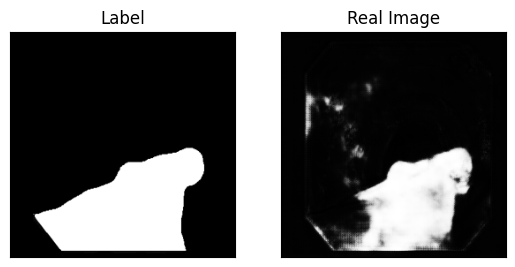

In [ ]:
model = unet.to(device)
model.load_state_dict(torch.load(f'model_at_epoch{epoch}.pth'))

images, targets = next( iter( test_dataloader ) )
images  = images.to(device)
targets = targets.to(device)

with torch.no_grad():
    pred = model(images)
    model_output = 255*pred.detach().cpu().numpy()


idx = 0
target = targets[idx].permute(1,2,0).cpu().numpy()
output = model_output[idx].squeeze()


plt.subplot(121),plt.imshow(target,cmap = 'gray')
plt.title('Label'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(output,cmap = 'gray')
plt.title('Real Image'), plt.xticks([]), plt.yticks([])

plt.show()
